In [3]:
#!/usr/bin/env python3 -u
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree.
from __future__ import print_function

import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
#from tqdm import tqdm

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# parser.add_argument('--model', default="ResNet18", type=str,
#                     help='model type (default: ResNet18)')
# parser.add_argument('--name', default='0', type=str, help='name of run')
# parser.add_argument('--seed', default=0, type=int, help='random seed')
# parser.add_argument('--batch-size', default=128, type=int, help='batch size')
# parser.add_argument('--epoch', default=200, type=int,
#                     help='total epochs to run')
# parser.add_argument('--no-augment', dest='augment', action='store_false',
#                     help='use standard augmentation (default: True)')
# parser.add_argument('--decay', default=1e-4, type=float, help='weight decay')
# parser.add_argument('--alpha', default=1., type=float,
#                     help='mixup interpolation coefficient (default: 1)')
# args = parser.parse_args()

params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "mixup-128-NormalAdvsTrain",
    "seed": 10,
    "batch_size": 128,
    "decay": 5e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 0.,
}

# %cd ../../

# Loading Data

In [4]:



use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if params["seed"] != 0:
    torch.manual_seed(params["seed"])

# Data
print('==> Preparing data..')
if params["augment"]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465),
        #                     (0.2023, 0.1994, 0.2010)),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5)),
    ])
else:
    print("no augmentation")
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=False,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=10,
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='./data', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

==> Preparing data..


# Helping functions

In [30]:
def shuffle_dat(x, batch_size, use_cuda):
    '''shuffles data of batch size'''
    
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
        
    return x[index,:], index

def mixup_data_nMixes(x, y, nMix, use_cuda=True, epsilon=.35):
    '''Returns mixed images for general number of mixings, targets of mixings, and mixing weights'''
    
    # Create weights in range [0,1], and sum to 1.0
    wts = np.random.dirichlet(np.ones(nMix))
    
    # Create tensor to hold all shuffled targets, has size (batch_size, nMix)
    if use_cuda:
        mixed_targs = torch.zeros(y.size()[0], nMix).cuda()
        mixed_indices = torch.zeros(nMix, x.size()[0]).cuda()
    else:
        mixed_targs = torch.zeros(y.size()[0], nMix)
        mixed_indices = torch.zeros(nMix, x.size()[0])
    
    batch_size = x.size()[0]
    
    # Initiate mixed x as original x with first weight, and first col of targets to be original targets
    mixed_x = 0*x
    mixed_x += wts[0]*x
    mixed_targs[:,0] = y
    mixed_indices[0,:] = torch.arange(0,batch_size)
    
    # Add shuffled images to mixed image with weights, accumulate mixed targets
    for i in range(1, nMix):
        shuffledX, index = shuffle_dat(x, batch_size, use_cuda) 
        mixed_x += wts[i]*shuffledX
        mixed_targs[:,i] = y[index]
        mixed_indices[i,:] = index
    
    return mixed_x, mixed_targs, mixed_indices, wts

def vertical_concat_mix(x, y, nMix, use_cuda=True, epsilon=.35):
    '''Returns mixed image for general number of vertical concats'''
    # Create weights in range [0,1], and sum to 1.0
    wts = np.random.dirichlet(np.ones(nMix))
    
    # Create tensor to hold all shuffled targets, has size (batch_size, nMix)
    if use_cuda:
        mixed_targs = torch.zeros(y.size()[0], nMix).cuda()
        mixed_indices = torch.zeros(nMix, x.size()[0]).cuda()
    else:
        mixed_targs = torch.zeros(y.size()[0], nMix)
        mixed_indices = torch.zeros(nMix, x.size()[0])
        
    batch_size = x.size()[0]
    num_rows = x.size()[2]
    
    # Initiate mixed image as first n rows of original image, accoring to the first weight, first set of targets are
    # original targets
    mixed_x = 0*x
    mixed_x[:,:,0:int(round(wts[0]*num_rows)),:] = x[:,:,0:int(round(wts[0]*num_rows)),:]
    mixed_targs[:,0] = y
    mixed_indices[0,:] = torch.arange(0,batch_size)
    start_row = int(round(wts[0]*num_rows))
    
    # Add subsequent number of rows to mixed image, accoring to weights, accumulate shuffled targets
    for i in range(1, nMix-1):
        shuffledX, index = shuffle_dat(x, batch_size, use_cuda)
        mixed_x[:,:,start_row:start_row + int(round(wts[i]*num_rows)),:] =  \
                                      shuffledX[:,:,start_row:start_row + int(round(wts[i]*num_rows)),:] 
        start_row += int(round(wts[i]*num_rows))
        mixed_targs[:,i] = y[index]
        mixed_indices[i,:] = index
    
    # Finish of mixed image with final concatenation, add final mixed targets
    shuffledX, index = shuffle_dat(x, batch_size, use_cuda)
    mixed_x[:,:,start_row:,:] =  \
                                      shuffledX[:,:,start_row:,:] 
    mixed_targs[:,-1] = y[index]
    mixed_indices[-1,:] = index
        
    return mixed_x, mixed_targs, mixed_indices, wts   

def horizontal_concat_mix(x, y, nMix, use_cuda=True, epsilon=.35):
    '''Returns mixed image for general number of horizontal concats''' 
    # Works the same as vertical_concat mix, but switches dimenions of concats.
    wts = np.random.dirichlet(np.ones(nMix))
    
    if use_cuda:
        mixed_targs = torch.zeros(y.size()[0], nMix).cuda()
        mixed_indices = torch.zeros(nMix, x.size()[0]).cuda()
    else:
        mixed_targs = torch.zeros(y.size()[0], nMix)
        mixed_indices = torch.zeros(nMix, x.size()[0])
        
    batch_size = x.size()[0]
    num_cols = x.size()[3]
    
    mixed_x = 0*x
    mixed_x[:,:,:,0:int(round(wts[0]*num_cols))] = x[:,:,:,0:int(round(wts[0]*num_cols))]
    mixed_targs[:,0] = y
    mixed_indices[0,:] = torch.arange(0,batch_size)
    start_col = int(round(wts[0]*num_cols))
    
    for i in range(1, nMix-1):
        shuffledX, index = shuffle_dat(x, batch_size, use_cuda)
        mixed_x[:,:,:,start_col:start_col + int(round(wts[i]*num_cols))] =  \
                                      shuffledX[:,:,:,start_col:start_col + int(round(wts[i]*num_cols))] 
        start_col += int(round(wts[i]*num_cols))
        mixed_targs[:,i] = y[index]
        mixed_indices[i,:] = index
        
    shuffledX, index = shuffle_dat(x, batch_size, use_cuda)
    mixed_x[:,:,:,start_col:] =  \
                                      shuffledX[:,:,:,start_col:] 
    mixed_targs[:,-1] = y[index]
    mixed_indices[-1,:] = index
        
    return mixed_x, mixed_targs, mixed_indices, wts   


def mixup_criterion_nMixes(criterion, pred, mixed_targs, wts):
    '''Returns total criterion for total mixed images'''
    
    # accumulate total criterion as weighted sum of shuffled targets, weighted with wts 
    total_criterion = 0
    for i in range(len(wts)):
        total_criterion += wts[i]*criterion(pred, mixed_targs[:,i])
    return(total_criterion)


# FMix

In [6]:
import zipfile as zf
!wget -O fmix.zip https://github.com/ecs-vlc/fmix/archive/master.zip
files = zf.ZipFile("fmix.zip", 'r')
files.extractall()
files.close()
!mv FMix-master/* ./
!rm -r FMix-master

--2021-04-12 16:26:59--  https://github.com/ecs-vlc/fmix/archive/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ecs-vlc/FMix/zip/master [following]
--2021-04-12 16:26:59--  https://codeload.github.com/ecs-vlc/FMix/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘fmix.zip’

fmix.zip                [  <=>               ] 983.14K  3.09MB/s    in 0.3s    

2021-04-12 16:26:59 (3.09 MB/s) - ‘fmix.zip’ saved [1006735]

mv: cannot move 'FMix-master/analysis' to './analysis': Directory not empty
mv: cannot move 'FMix-master/datasets' to './datasets': Directory not empty
mv: cannot move 'FMix-master/experiments' to

In [38]:
# Helper functions for F-mixing 
from fmix import make_low_freq_image, binarise_mask

def make_masks(DECAY_POWER, LAMBDA, SHAPE, NUM_IMAGES):
    '''Makes the masks for mixing two images'''
    soft_masks_np = [make_low_freq_image(DECAY_POWER, [SHAPE, SHAPE]) for _ in range(NUM_IMAGES)]
    soft_masks = torch.from_numpy(np.stack(soft_masks_np, axis = 0)).float().repeat(1, 3, 1, 1)

    masks_np = [binarise_mask(mask, LAMBDA, [SHAPE, SHAPE]) for mask in soft_masks_np]
    masks = torch.from_numpy(np.stack(masks_np, axis = 0)).float().repeat(1, 3, 1, 1)
    
    return(masks)
    
def F_mix(x, y, use_cuda=True):
    '''applies f-mix method''' 
    # This method works like a usual mixing of two images, 'lam' is the weight of the first, 
     # (1-'lam') is the weight of the second image
    DECAY_POWER = 3
    lam = 0.5
    batch_size = x.size()[0]
    masks = make_masks(DECAY_POWER, lam, x.shape[-1], batch_size)
        
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
        mixed_indices = torch.zeros(2, x.size()[0]).cuda()
    else:
        index = torch.randperm(batch_size)
        mixed_indices = torch.zeros(2, x.size()[0])
            
    mixed_x = x*masks + x[index, :]*(1-masks)
    y_a, y_b = y, y[index]
    mixed_indices[0,:] = torch.arange(0,batch_size)
    mixed_indices[1,:] = index
    lam = masks[:,1,:,:]
        
    return mixed_x, y_a, y_b, mixed_indices, lam 


# Demonstrations

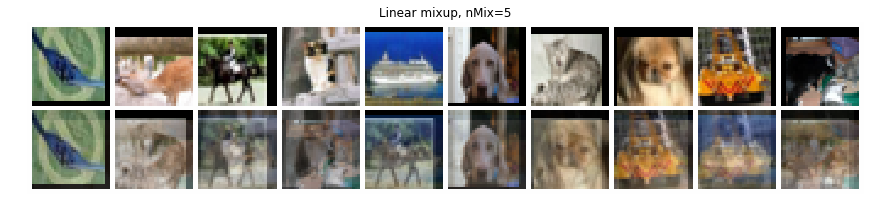

tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
        [0., 6., 3., 9., 2., 5., 7., 8., 4., 1.],
        [1., 6., 7., 5., 9., 0., 2., 4., 3., 8.],
        [7., 6., 3., 9., 2., 4., 8., 1., 5., 0.],
        [0., 9., 4., 5., 6., 1., 7., 8., 3., 2.]])


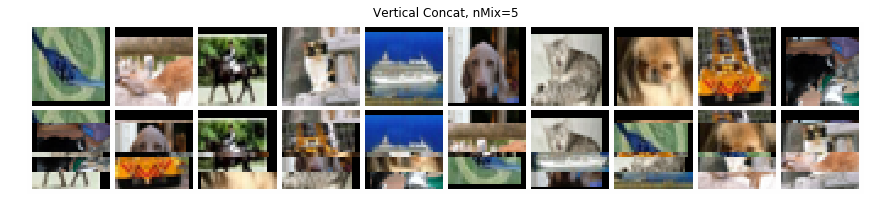

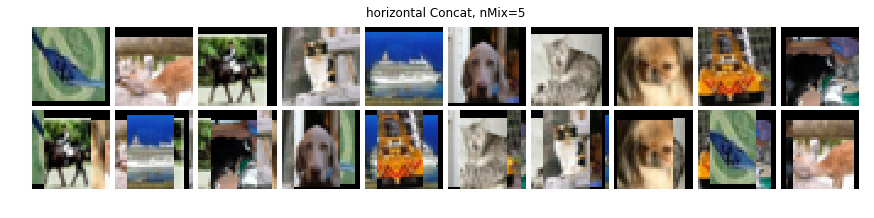

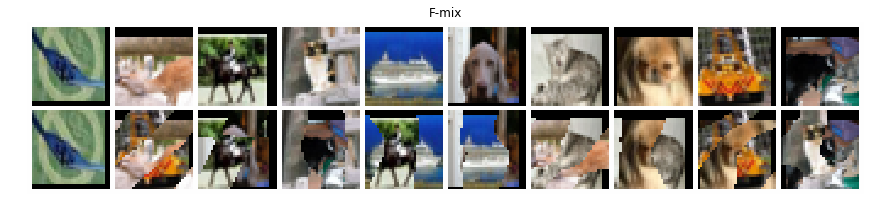

In [41]:
from torchvision.utils import save_image, make_grid

%matplotlib inline
import matplotlib.pyplot as plt
x, target = next(iter(trainloader))
nMix=5

mixed_x, mixed_targs, mixed_indices, wts = mixup_data_nMixes(x, target, nMix, use_cuda=False, epsilon=.35)
image = torch.cat((x, mixed_x), 0)
plt.figure(figsize=(15,10))
plt.imshow(make_grid(image/2+0.5, nrow=10, pad_value=2).permute(1,2,0).numpy())
_ = plt.axis('off')
plt.title("Linear mixup, nMix="+str(nMix))
plt.show()

print(mixed_indices)

mixed_x, mixed_targs, mixed_indices, wts = vertical_concat_mix(x, target, nMix, use_cuda=False, epsilon=.35)
image = torch.cat((x, mixed_x), 0)
plt.figure(figsize=(15,10))
plt.imshow(make_grid(image/2+0.5, nrow=10, pad_value=2).permute(1,2,0).numpy())
_ = plt.axis('off')
plt.title("Vertical Concat, nMix="+str(nMix))
plt.show()

mixed_x, mixed_targs, mixed_indices, wts = horizontal_concat_mix(x, target, nMix, use_cuda=False, epsilon=.35)
image = torch.cat((x, mixed_x), 0)
plt.figure(figsize=(15,10))
plt.imshow(make_grid(image/2+0.5, nrow=10, pad_value=2).permute(1,2,0).numpy())
_ = plt.axis('off')
plt.title("horizontal Concat, nMix="+str(nMix))
plt.show()

mixed_x, y_a, y_b, mixed_indices, wts = F_mix(x, target, use_cuda=False)
x = x/2 + 0.5
mixed_x = mixed_x/2 + 0.5
image = torch.cat((x, mixed_x), 0)
plt.figure(figsize=(15,10))
plt.imshow(make_grid(image, nrow=10, pad_value=2).permute(1,2,0).numpy())
_ = plt.axis('off')
plt.title("F-mix")
plt.show()

